# Demonstration: Dislocation Nye Tensor

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2015-08-28

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)

- - -

## Software

This notebook was tested with:

- LAMMPS (Version 2015-03-27)

- Python (Version 2.7.6)

- IPython (Version 2.0.0)

- - -

## Introduction

This Notebook calculates the Nye tensor for all atoms in a dislocation containing system. 

Related calculations:

- tool-Dislocation-Creation: creates an atomic system containing a dislocation monopole.

- tool-Dislocation-Differential-Displacement: creates a differential displacement plot.


- - -

##1. Initial Setup

1. __Necessary Python Libraries__: This is a list of the Python libraries used to run this code. 

2. __Necessary Parameters__: These are the parameters that need to be specified to run the code.

3. __Calculation Parameters__: These are user-specified parameters that control how the calculation proceeds, such as number of data points.

###1.1 Necessary Python Libraries

This is a list of the Python libraries used to run this code. 

- scipy can be found [here](http://www.scipy.org/).

- Numpy can be found [here](http://www.numpy.org/).

- Matplotlib can be found [here](http://matplotlib.org/).

- iprp is contained in the IPR code download.

In [1]:
#Standard Python Libraries
import os
from copy import deepcopy
import sys

#Additional Python Libraries
from scipy.interpolate import griddata
import numpy as np
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import PatchCollection

#Custom package
import atomman as am

###1.2 Necessary Parameters

These are the parameters that need to be specified to run the code.

__Note:__ The default example shown here assumes that you have previously run the default example for the tool-Dislocation-Creation Notebook.  The directory and file information supplied here refers to what was created using that tool.

- working_dir is the working directory where you want this Notebook to run. 

- dump_file is the name (and location) of the LAMMPS dump file that you want to run the Nye tensor analysis on.

- elements is a list of the elements to be associated with the atom types in the dump_file.  Note that with systems created by the tool-Dislocation-Creation Notebook, the atom types are doubled.  For example, if you have a three element system, then elements = [El1, El2, El3, El1, El2, El3].

- a0 is the lattice parameter a for the system. This is used here to properly scale dimensions used in the plotting. 

- disl_file is the name (and location) of the dislocation monopole library data model file.  This is used here as each crystal prototype requires specific inputs related to performing the Nye tensor calculation.

- disl_type is the specific tag associated with a particular dislocation type listed in the disl_file.  

In [2]:
#Specify working directory
working_dir = 'tool-Dislocation'
os.chdir(working_dir)
working_dir = os.getcwd()

#Specify LAMMPS dump file to calculate Nye tensor on
dump_file = 'fcc--Al--(a-2)[(1)(0)(-1)]--((1)(1)(1))--u[(1)(0)(-1)]--disl.dump'
#dump_file = 'fcc--Al--(a-2)[(1)(0)(-1)]--((1)(1)(1))--u[(1)(-2)(1)]--disl.dump'

#List the elements to use. 
#symbols = ['AlS', 'AlS']

#Give the lattice parameter a
a = 4.0500

#Specify point defect library data model file
disl_file = 'fcc-disl.json'

#Specify which dislocation type was used
disl_type = '(a-2)[(1)(0)(-1)]--((1)(1)(1))--u[(1)(0)(-1)]'
#disl_type = '(a-2)[(1)(0)(-1)]--((1)(1)(1))--u[(1)(-2)(1)]'

###1.3 Calculation Parameters

These are user-specified parameters that control how the calculation proceeds, such as number of data points.

- xy_plot_range defines the xy window of the system to use in creating the plot.

In [3]:
xy_plot_range = [[-15, 15], [-15, 15]]

##2. Additional Data Files

To make this notebook self-contained, we have embedded a few files.

None for this calculation.

__Note:__ The default example shown here assumes that you have previously run the default example for the tool-Dislocation-Creation Notebook.  The necessary files are created using that tool.

##3. LAMMPS Script Generation Function(s)

This code generates the underlying LAMMPS script(s) for performing the necessary simulations.  

None for this calculation

##4. Python Calculation Function(s)

These functions are associated with setting up the atomic systems, running LAMMPS, extracting the simulation data, and refining the results.

1. __Calculation Functions:__ these are functions directly associated with performing the Nye tensor calculation.

2. __Plotting Functions:__ these are functions only concerned with creating nice looking plots.

###4.1 Calculation Functions

These are functions directly associated with performing the Nye tensor calculation.

- ax_check() checks that a crystallographic axes set is orthogonal and returns both the associated normalization vectors and the magnitudes associated with those directions.  Note that the normalized vector array is the transformation matrix, T, relative to a [1,0,0],[0,1,0],[0,0,1] orientation.

- mag() returns the magnitude of a vector of any dimension.

- nye() computes the Nye tensor for a given system.  It requires that the axes and neighbor list information be previously set as System properties.  The additional parameters p and tmax are crystal Prototype specific (read in from the disl_file).

In [4]:
#Checks that the axes are orthogonal and returns normalized direction vectors
#The normalized array is the transformation matrix, T, relative to a [1,0,0],[0,1,0],[0,0,1] orientation
def axes_check(axes, tol=1e-8):
    mag = np.apply_along_axis(np.linalg.norm, 1, axes)
    uaxes = axes / mag[:,None]
    if (np.isclose(np.dot(uaxes[0], uaxes[1]), 0., atol=tol) == False or 
        np.isclose(np.dot(uaxes[0], uaxes[2]), 0., atol=tol) == False or 
        np.isclose(np.dot(uaxes[1], uaxes[2]), 0., atol=tol) == False):
        raise ValueError('dots are not 0!')
    if np.allclose(np.cross(uaxes[0], uaxes[1]) - uaxes[2], np.zeros(3), atol=tol) == False:
        raise ValueError('cross does not check!')
    return uaxes, mag

def mag(vect):
    #return np.linalg.norm(vect)  Runs slower...
    m = 0
    for v in vect:
        m += v**2
    return (m)**.5  

def nye(system, p, tmax = 27):
    axes = system.prop('axes')
    nlist = system.prop('nlist')
    natoms = system.natoms()
    
    T,vmag = axes_check(axes)
    if len(p) == 1:
        p = p[0]
    else:
        raise ValueError('Multiple unique sites not supported yet')
    
    p = p.dot(np.transpose(T))
    
    #Change tmax=angle to tmax=cos(angle)
    tmax = np.cos(tmax * np.pi / 180)  
    iden = np.identity(3)
    eps = np.array([[[ 0, 0, 0],[ 0, 0, 1],[ 0,-1, 0]],
                    [[ 0, 0,-1],[ 0, 0, 0],[ 1, 0, 0]],
                    [[ 0, 1, 0],[-1, 0, 0],[ 0, 0, 0]]])
    
    #Set r1 to smallest interatomic distance from p
    r1 = 50.
    for pi in p:
        if r1 > mag(pi): r1 = mag(pi)
    
    #Identify largest number of nearest neighbors
    nmax = 0
    for ns in nlist:
        if ns[0] > nmax: nmax=ns[0]
    
    #Initialize variables (done here to reduce memory allocations making it slightly faster)
    q = np.zeros((nmax, 3))
    temp = [-1 for y in xrange(nmax)]
    P = np.zeros((nmax, 3))            
    Q = np.zeros((nmax, 3))
    G = [[] for y in xrange(natoms)]
    nye = np.zeros((3, 3))
    gradG = np.zeros((3, 3, 3))
    
    #Loop to calculate correspondence tensor, G, and strain data   
    for i in xrange(natoms):
        #Reset temp list used to identify p-q pairs
        for t in xrange(len(temp)):
            temp[t] = -1
        
        #Calculate radial neighbor vectors, q, and associate to perfect crystal vectors, p using theta.
        #Only match p-q if cos(angle) between them is largest and greater than tmax.
        for n in xrange(nlist[i][0]):
            j = nlist[i][n+1]
            q[n] = system.dvect(i, j)
            theta = tmax
            for s in xrange(len(p)):
                if (p[s].dot(q[n]) / (mag(p[s]) * mag(q[n])) > theta):
                    temp[n] = s
                    theta = p[s].dot(q[n]) / (mag(p[s]) * mag(q[n]))
                       
            #Check if the particular p has already been assigned to another q
            #Remove the p-q pair that is farther from r1
            if temp[n] >=0:
                for k in xrange(n):
                    if temp[n] == temp[k]:
                        nrad = abs(r1 - mag(q[n]))
                        krad = abs(r1 - mag(q[k]))
                        if nrad < krad:
                            temp[k]=-1
                        else:
                            temp[n]=-1

        #Construct reduced P, Q matrices from p-q pairs
        c = 0
        for n in xrange(nlist[i][0]):
            if temp[n] >= 0:
                Q[c] = q[n]
                P[c] = p[temp[n]]
                c+=1   
        #Compute lattice correspondence tensor, G, from P and Q
        if c == 0:
            G[i] = iden
            print i+1
            raise ValueError('An atom lacks pair sets. Check neighbor list')
        else:   
            G[i], resid, rank, s = np.linalg.lstsq(Q[:c], P[:c])
        
        #Compute strain properties
        strain = ((iden - G[i]) + (iden - G[i]).T) / 2.
        inv1 = strain[0,0] + strain[1,1] + strain[2,2]
        inv2 = (strain[0,0] * strain[1,1] + strain[0,0] * strain[2,2] + strain[1,1] * strain[2,2] 
                - strain[0,1]**2 - strain[0,2]**2 - strain[1,2]**2)
        rot = ((iden - G[i]) - (iden - G[i]).T) / 2.
        ang_vel = (rot[0,1]**2 + rot[0,2]**2 + rot[1,2]**2)**0.5
        
        system.atoms(i, 'strain', strain)
        system.atoms(i, 'strain_invariant_1', inv1)
        system.atoms(i, 'strain_invariant_2', inv2)
        system.atoms(i, 'angular_velocity', ang_vel)

    #Construct the gradient tensor of G, gradG
    for i in xrange(natoms):
        for x in xrange(3):
            for y in xrange(3):
                Q = np.zeros((nlist[i][0], 3))
                dG = np.zeros((nlist[i][0]))
                for n in xrange(nlist[i][0]):
                    j = nlist[i][n+1]
                    Q[n] = system.dvect(i, j)
                    dG[n] = G[j][x,y] - G[i][x,y]
                gradG[x, y], resid, rank, s = np.linalg.lstsq(Q, dG)  
        
        #Use gradG to build the nye tensor, nye
        for ij in xrange(3):
            nye[0,ij] = -gradG[2, ij, 1] + gradG[1, ij, 2]
            nye[1,ij] = -gradG[0, ij, 2] + gradG[2, ij, 0]
            nye[2,ij] = -gradG[1, ij, 0] + gradG[0, ij, 1]
                
        system.atoms(i, 'Nye', nye)

###4.2 Plotting Functions

These are functions only concerned with creating nice looking plots.

- grid_interpolate_2d() takes an array of 2D points and values associated with them and interpolates to create a distribution map.  Returns the spacial integer sum of the value over the plot range.  

- prettygrid() is used to set up the scaling of the figure in nice ways.

- adddots() adds points to the plot.

- a2cplot() uses the above functions to convert a series of atom points and values into a property distribution map.

In [5]:
def grid_interpolate_2d(x, y, v, bins=50, range=None):
    #Handle range and bins options
    if range is None:
        range=[[x.min() ,x.max()], [y.min(), y.max()]]
    if isinstance(bins, int):
        xi = np.linspace(range[0][0], range[0][1], num=bins)
        yi = np.linspace(range[1][0], range[1][1], num=bins)
    elif isinstance(bins, list) or isinstance(bob, tuple) or isinstance(bins, np.ndarray):
        if len(bins)==2 and isinstance(bins[0], int) and isinstance(bins[1], int):
            xi = np.linspace(range[0][0], range[0][1], num=bins[0])
            yi = np.linspace(range[1][0], range[1][1], num=bins[1])
    
    #Create continuum grid from atomic information
    x0, y0 = np.meshgrid(xi, yi)
    
    grid = griddata((x, y), v, (x0, y0))
    
    return grid, range[0], range[1]

def prettygrid(grid, xedges, yedges, cmap=cm.get_cmap('jet'), propname='', czero=True, scale=1):

    #This scales the color plot to be fancy
    #czero=True makes zero the halfway point of the scale
    if czero:
        vmax = abs(grid).max()
        if vmax != 0.0:
            vrounder = np.floor(np.log10(vmax))
            vmax = np.around(2 * vmax / 10.**vrounder) * 10.**vrounder / 2.
        else:
            vmax = 1e-15
        vmin = -vmax
    else:
        vmax = grid.max()
        vmin = grid.min()
        if abs(grid).max() != 0.0:
            vrounder = np.floor(np.log10(abs(grid).max()))
            vmax = np.around(2 * vmax / 10.**vrounder) * 10.**vrounder / 2.
            vmin = np.around(2 * vmin / 10.**vrounder) * 10.**vrounder / 2.
            if vmax == vmin:
                if vmax > 0:
                    vmin = 0
                else:
                    vmax = 0
        else:
            vmax = 1e-15
            vmin = -1e-15
    vmin*=scale
    vmax*=scale
    
    vticks = np.linspace(vmin, vmax, 11, endpoint=True)

    #Plot figure on screen
    fig = plt.figure(figsize=(7.7, 7), dpi=72)
    plt.imshow(grid, extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]], 
               cmap=cmap, norm=plt.Normalize(vmax=vmax, vmin=vmin))
    
    #Make colorbar pretty
    cbar = plt.colorbar(fraction=0.05, pad = 0.05, ticks=vticks)
    cbar.ax.tick_params(labelsize=15)
   
    #Make axis values and title pretty
    plt.xlim(xedges[0], xedges[-1])
    plt.xticks(size=15)
    plt.ylim(yedges[0], yedges[-1])
    plt.yticks(size=15)
    plt.title(propname, size=30)
    return fig

def adddots(x, y, xedges, yedges):
    points = []
    ax = plt.gca()
    syswidth = max([abs(xedges[-1]-xedges[0]), abs(yedges[-1]-yedges[0])])
    linewidth = 60. / syswidth
    for i in xrange(len(x)):
        point = mpatches.Circle((x[i], y[i]), 0.3, ls='solid', lw=linewidth)
        ax.add_artist(point)
        point.set_facecolor('none')
        point.set_edgecolor('k')
        
def a2cplot(system, value, index1=None, index2=None, plotbounds=None, bins=200, dots=True, czero=True, save=False, show=True):
    
    if save is False and show is False:
        print 'Figure not saved or displayed!'
    
    test = system.atoms(0, value, index1, index2)
    assert test is not None, 'atomic value not found!'
    assert (test.dtype == np.int or test.dtype == np.float) and len(test.shape) == 0, 'Value field is not a scalar number!' 
    
    name = str(value)
    if index1 is not None:
        name += '[' + str(index1) + ']'
        if index2 is not None:
            name += '[' + str(index2) + ']'
    
    if plotbounds is None:
        plotbounds = np.array([[system.box('xlo'), system.box('xhi')],
                               [system.box('ylo'), system.box('yhi')],
                               [system.box('zlo'), system.box('zhi')]])
    
    #Build arrays containing atomic information
    natoms = system.natoms()    
    x = np.empty(natoms)
    y = np.empty(natoms)
    v = np.empty(natoms)
    numv = 0
    for i in xrange(natoms):
        pos = system.atoms(i, 'pos')

        if pos[0] > plotbounds[0,0] - 5. and pos[0] < plotbounds[0,1] + 5.:
            if pos[1] > plotbounds[1,0] - 5. and pos[1] < plotbounds[1,1] + 5.:
                if pos[2] > plotbounds[2,0] and pos[2] < plotbounds[2,1]:
                    x[numv] = pos[0]
                    y[numv] = pos[1]
                    v[numv] = system.atoms(i, value, index1, index2)
                    numv +=1
    x = x[:numv]
    y = y[:numv]
    v = v[:numv]

    box = plotbounds[:2,:2]
    grid, xedges, yedges = grid_interpolate_2d(x, y, v, bins=bins, range=box)

    intsum = np.sum(grid)
    avsum = intsum / (bins-1) / (bins-1)
    intsum = intsum * (plotbounds[0,1]-plotbounds[0,0]) / (bins-1) * (plotbounds[1,1]-plotbounds[1,0]) / (bins-1)
        
    fig = prettygrid(grid, xedges, yedges, propname=name, czero=czero)
    if dots:
        adddots(x, y, xedges, yedges)
    if save:
        plt.savefig(name + '.png', dpi=800)
    if show==False:
        plt.close(fig)
    plt.show() 
 
    return intsum, avsum

##5. Run Calculation and Display Results

This is the code that runs the calculation function(s) for the supplied inputs and displays the resulting data.

In [6]:
#Read the data model files
dislocations = am.tools.DislocationMonopole(disl_file)

#Define run parameters
axes = dislocations.get(disl_type, 'axes')

cutoff = a * dislocations.get('Nye_cutoff')
tmax = dislocations.get('Nye_angle')
p = []
for pset in dislocations.get('Nye_p'):
    p.append(a * pset)
        
#Read in the dislocation containing system
sys2 = am.lammps.read_dump(dump_file)
sys2.prop('axes', axes)

#Calculate nearest neighbor list
sys2.neighbors(cutoff)
print 'Neighbor list created'

#Calculate the Nye tensor and save over 
nye(sys2, p, tmax)
print 'Nye Tensor calculated'
am.lammps.write_dump(dump_file, sys2)

Neighbor list created
Nye Tensor calculated


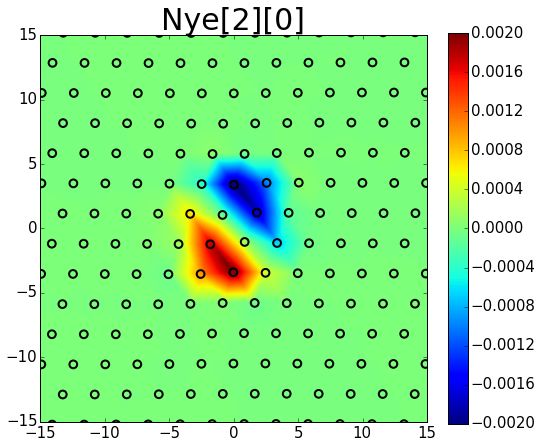

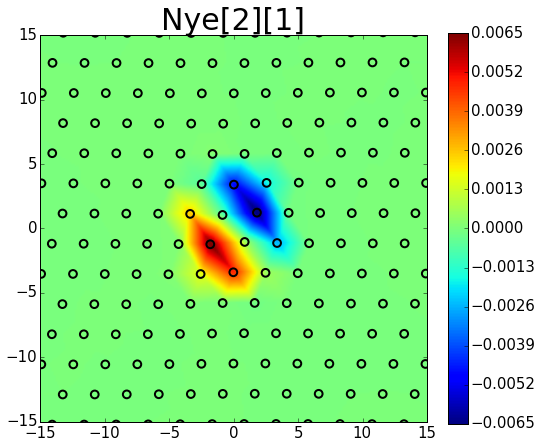

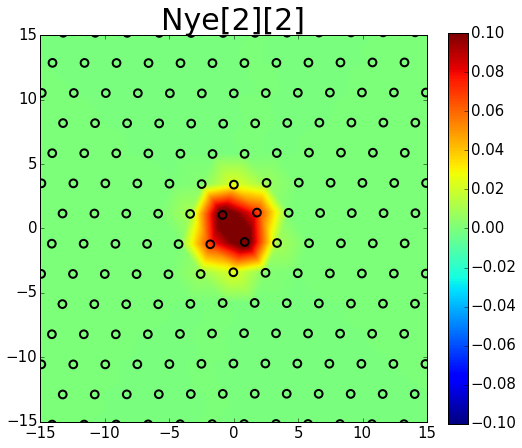

Nye Tensor estimated Burgers vector is: [-0.000, -0.000, 2.772]


In [7]:
#Create and save plots
plot_range = np.array([xy_plot_range[0], xy_plot_range[1], a * dislocations.get(disl_type, 'zwidth') ])

#Change plot file names to avoid conflicts
dot_index = dump_file.index('.')
fname = dump_file[:dot_index]

#Plot Nye[2][0], i.e. zx component
bx, avsum = a2cplot(sys2, 'Nye', 2, 0, plotbounds=plot_range, save=True)
try:
    os.rename('Nye[2][0].png', fname + '--Nye[2][0].png')
except:
    os.remove(fname + '--Nye[2][0].png')
    os.rename('Nye[2][0].png', fname + '--Nye[2][0].png')

#Plot Nye[2][1], i.e. zy component
by, avsum = a2cplot(sys2, 'Nye', 2, 1, plotbounds=plot_range, save=True)
try:
    os.rename('Nye[2][1].png', fname + '--Nye[2][1].png')
except:
    os.remove(fname + '--Nye[2][1].png')
    os.rename('Nye[2][1].png', fname + '--Nye[2][1].png')

#Plot Nye[2][2], i.e. zz component
bz, avsum = a2cplot(sys2, 'Nye', 2, 2, plotbounds=plot_range, save=True)
try:
    os.rename('Nye[2][2].png', fname + '--Nye[2][2].png')
except:
    os.remove(fname + '--Nye[2][2].png')
    os.rename('Nye[2][2].png', fname + '--Nye[2][2].png')
    
print 'Nye Tensor estimated Burgers vector is: [%.3f, %.3f, %.3f]' % (bx, by, bz)